In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import sagemaker
import boto3
from io import BytesIO

module_path = os.path.abspath(os.path.join('../py-conjugated/networks/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import morphology_networks as net
import model_training as train
import model_testing as test
import physically_informed_loss_functions as PhysLoss
import network_utils as nuts

torch.manual_seed(28)

In [2]:
client = boto3.client('s3')
resource = boto3.resource('s3')
s3_bucket = resource.Bucket('sagemaker-us-east-2-362637960691')

In [26]:
image_data_location = 'py-conjugated/m2py_labels/OPV_labels/'
model_states_location = 's3://sagemaker-us-east-2-362637960691/py-conjugated/model_states/OPV/'

files = list(s3_bucket.objects.filter(Prefix = image_data_location))
print(files)



[s3.ObjectSummary(bucket_name='sagemaker-us-east-2-362637960691', key='py-conjugated/m2py_labels/OPV_labels/'), s3.ObjectSummary(bucket_name='sagemaker-us-east-2-362637960691', key='py-conjugated/m2py_labels/OPV_labels/100C_15min_Sub4_Dev2_domain_metrics.csv'), s3.ObjectSummary(bucket_name='sagemaker-us-east-2-362637960691', key='py-conjugated/m2py_labels/OPV_labels/100C_15min_Sub4_Dev2_seg1.npy'), s3.ObjectSummary(bucket_name='sagemaker-us-east-2-362637960691', key='py-conjugated/m2py_labels/OPV_labels/100C_15min_Sub4_Dev2_seg2.npy'), s3.ObjectSummary(bucket_name='sagemaker-us-east-2-362637960691', key='py-conjugated/m2py_labels/OPV_labels/100C_15min_Sub4_Dev4_domain_metrics.csv'), s3.ObjectSummary(bucket_name='sagemaker-us-east-2-362637960691', key='py-conjugated/m2py_labels/OPV_labels/100C_15min_Sub4_Dev4_seg1.npy'), s3.ObjectSummary(bucket_name='sagemaker-us-east-2-362637960691', key='py-conjugated/m2py_labels/OPV_labels/100C_15min_Sub4_Dev4_seg2.npy'), s3.ObjectSummary(bucket_name

In [27]:
im_dict = {}
for obj in im_files[1:]:
#     print(obj.bucket_name)
#     print(obj.key)
    fl = obj.key[37:]
#     print(fl)
    
    if obj.key[-1] == 'v':
        pass
    elif obj.key[-1] == 'e':
        pass
    else:
        
        anl_temp = 0
        anl_time = 0

        if i < len(im_files)-1:
            if fl[:-6] == im_files[i+1][:-6]:
                seg1 = np.load(im_directory+fl)
                seg2 = np.load(im_directory+files[i+1])
                sample = np.stack([seg1, seg2], axis = -1)
                sample = sample.astype(np.double)
    #             print (sample.dtype)

                im_index = len(image_dict)

                image_dict[im_index] = sample

                if 'NOANNEAL' in fl:
                    im_labels[i] = [anl_temp, anl_time]

                else:
                    temp_stop_indx = fl.index('C')
                    anl_temp = int(fl[:temp_stop_indx])

                    time_start_indx = temp_stop_indx+2
                    time_stop_indx = fl.index('m')
                    time_stop_indx = time_stop_indx
                    anl_time = fl[time_start_indx:time_stop_indx]
                    anl_time = int(anl_time)

                    im_labels[i] = [anl_temp, anl_time]

            else:
                pass
        
        
            im = np.load(BytesIO(obj.get()['Body'].read()))
    #         print(im.shape)
            im_dict[fl] = im

72
dict_keys(['100C_15min_Sub4_Dev2_seg1.npy', '100C_15min_Sub4_Dev2_seg2.npy', '100C_15min_Sub4_Dev4_seg1.npy', '100C_15min_Sub4_Dev4_seg2.npy', '100C_15min_Sub4_Dev7_seg1.npy', '100C_15min_Sub4_Dev7_seg2.npy', '100C_30min_Sub7_Dev2_seg1.npy', '100C_30min_Sub7_Dev2_seg2.npy', '100C_30min_Sub7_Dev4_seg1.npy', '100C_30min_Sub7_Dev4_seg2.npy', '100C_30min_Sub7_Dev7_seg1.npy', '100C_30min_Sub7_Dev7_seg2.npy', '100C_5min_Sub1_Dev3_seg1.npy', '100C_5min_Sub1_Dev3_seg2.npy', '100C_5min_Sub1_Dev4_90D_seg1.npy', '100C_5min_Sub1_Dev4_90D_seg2.npy', '100C_5min_Sub1_Dev4_seg1.npy', '100C_5min_Sub1_Dev4_seg2.npy', '125C_15min_Sub4_Dev1_seg1.npy', '125C_15min_Sub4_Dev1_seg2.npy', '125C_15min_Sub4_Dev2_seg1.npy', '125C_15min_Sub4_Dev2_seg2.npy', '125C_15min_Sub4_Dev6_seg1.npy', '125C_15min_Sub4_Dev6_seg2.npy', '125C_15min_Sub4_Dev7_seg1.npy', '125C_15min_Sub4_Dev7_seg2.npy', '125C_15min_Sub4_postexam_seg1.npy', '125C_15min_Sub4_postexam_seg2.npy', '125C_30min_Sub8_Dev3_seg1.npy', '125C_30min_Sub8_De

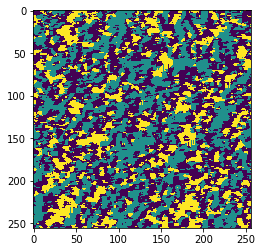

In [32]:
print(len(im_dict))
print(im_dict.keys())
plt.imshow(im_dict['100C_15min_Sub4_Dev2_seg1.npy'])

In [33]:
image_dict = {} # Hold all the image-like data
im_labels = {} # Gather all the processing conditions to be the predicted feature

for i,fl in enumerate(files):
    
    anl_temp = 0
    anl_time = 0
    
    if i < len(files)-1:
        if fl[:-6] == files[i+1][:-6]:
            seg1 = np.load(im_directory+fl)
            seg2 = np.load(im_directory+files[i+1])
            sample = np.stack([seg1, seg2], axis = -1)
            sample = sample.astype(np.double)
#             print (sample.dtype)
            
            im_index = len(image_dict)
            
            image_dict[im_index] = sample
            
            if 'NOANNEAL' in fl:
                im_labels[i] = [anl_temp, anl_time]

            else:
                temp_stop_indx = fl.index('C')
                anl_temp = int(fl[:temp_stop_indx])
                
                time_start_indx = temp_stop_indx+2
                time_stop_indx = fl.index('m')
                time_stop_indx = time_stop_indx
                anl_time = fl[time_start_indx:time_stop_indx]
                anl_time = int(anl_time)

                im_labels[i] = [anl_temp, anl_time]

        else:
            pass
    
im_labels_df = pd.DataFrame.from_dict(im_labels, orient = 'index')
    
print (len(image_dict))
print (image_dict[0].shape)
print (im_labels_df.shape)
im_labels_df.head()

NameError: name 'files' is not defined

In [ ]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/OPVCNN/'

role = sagemaker.get_execution_role()

In [ ]:
im_filepaths = os.listdir(im_directory)
# print (im_filepaths)

files = []

for fl in im_filepaths:
    if fl[-1] == 'v':
        pass
    elif fl[-1] == 'e':
        pass
    else:
        files.append(fl)
        
print (len(files))
print (files)

In [ ]:
image_dict = {} # Hold all the image-like data
im_labels = {} # Gather all the processing conditions to be the predicted feature

for i,fl in enumerate(files):
    
    anl_temp = 0
    anl_time = 0
    
    if i < len(files)-1:
        if fl[:-6] == files[i+1][:-6]:
            seg1 = np.load(im_directory+fl)
            seg2 = np.load(im_directory+files[i+1])
            sample = np.stack([seg1, seg2], axis = -1)
            sample = sample.astype(np.double)
#             print (sample.dtype)
            
            im_index = len(image_dict)
            
            image_dict[im_index] = sample
            
            if 'NOANNEAL' in fl:
                im_labels[i] = [anl_temp, anl_time]

            else:
                temp_stop_indx = fl.index('C')
                anl_temp = int(fl[:temp_stop_indx])
                
                time_start_indx = temp_stop_indx+2
                time_stop_indx = fl.index('m')
                time_stop_indx = time_stop_indx
                anl_time = fl[time_start_indx:time_stop_indx]
                anl_time = int(anl_time)

                im_labels[i] = [anl_temp, anl_time]

        else:
            pass
    
im_labels_df = pd.DataFrame.from_dict(im_labels, orient = 'index')
    
print (len(image_dict))
print (image_dict[0].shape)
print (im_labels_df.shape)
im_labels_df.head()

In [ ]:
X_im = image_dict #input features used to make prediction
Y_im = im_labels_df #target features to be predicted

x_im_train, x_im_test, y_im_train, y_im_test = train_test_split(X_im,Y_im, test_size = 0.2, shuffle = True) #split dataset into separate testing and training datasets

In [ ]:
# Hyper parameters
num_epochs = 10
im_batch_size = int(len(x_im_train[0])*0.9) # 90% of x_train samples
im_learning_rate = 0.008

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
x_im_train_tensor = torch.tensor(x_im_train).float() #for conv2d, inputs need to be doubles
y_im_train_tensor = torch.tensor(y_im_train.values.astype(np.float32)).float()#convert pd.DataFrame -> np.ndarray -> torch.tensor
x_im_train_tensor = x_im_train_tensor.view(28, 2, 256, 256) #convert tensor of size [28, 256, 256, 2] to [28, 2, 256, 256] to fit Conv2D parameters
im_train_tensor = torch.utils.data.TensorDataset(x_im_train_tensor, y_im_train_tensor) #create tensor with features and targets
im_training_data_set = torch.utils.data.DataLoader(dataset = im_train_tensor, batch_size = im_batch_size, shuffle = True) #create iterable dataset with batches

x_im_test_tensor = torch.tensor(x_im_test).float()
y_im_test_tensor = torch.tensor(y_im_test.values.astype(np.float32)).float()
x_im_test_tensor = x_im_test_tensor.view(8, 2, 256, 256) #convert tensor of size [8, 256, 256, 2] to [8, 2, 256, 256] to fit Conv2D parameters
im_test_tensor = torch.utils.data.TensorDataset(x_im_test_tensor, y_im_test_tensor)
im_testing_data_set = torch.utils.data.DataLoader(dataset = im_test_tensor, batch_size = im_batch_size, shuffle = True)


im_x, im_y, im_z = X_im[0].shape

In [ ]:
im_branch_model = net.OPV_m2py_NN(im_z)

#define the loss function and the optimizer
im_criterion = nn.CrossEntropyLoss()
im_optimizer = torch.optim.Adam(im_branch_model.parameters(), lr = im_learning_rate)


In [ ]:
%autoreload

im_train_epoch_losses = []
im_test_epoch_losses = []

for epoch in range(num_epochs):
    
    # First Train the image branch
    im_train_epoch_loss = train.train_OPV_m2py_model(model = im_branch_model,
                                   training_data_set = im_training_data_set,
                                   criterion = im_criterion,
                                   optimizer = im_optimizer)
    
    im_train_epoch_losses.append(im_train_epoch_loss)
    
    im_test_epoch_loss = test.eval_OPV_m2py_model(model = im_branch_model,
                                 testing_data_set = im_testing_data_set,
                                 criterion = im_criterion)
    
    im_test_epoch_losses.append(im_test_epoch_loss)

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, im_train_epoch_losses, c = 'k', label = 'training error')
plt.plot(epochs, im_test_epoch_losses, c = 'r', label = 'testing error')
plt.legend(loc = 'upper right')
plt.show()